# Camera calibration

- In this section, I wanna calibrate the camera to get the camera matrix:<img src="cameraMatrix.png" width="200" height="200"> based on the opencv Camera Calibration template.

In [151]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math

In [152]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 26, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('img/*.jpg')


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imshow('gray',gray)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    print(ret)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

True
True
True
True
True
True
True
True
True
True
True


In [153]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
K= mtx

[[3.60700612e+03 0.00000000e+00 1.46342552e+03]
 [0.00000000e+00 3.56688419e+03 1.92973393e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [57]:
def cylindricalWarpImage(img1, K, savefig):
    fx = K[0,0]
    fy = K[1,1]
    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    (cyl_h,cyl_w) = cyl.shape[:2]
    
    x_c = K[0,2]
    y_c = K[1,2]
#     x_c = float(cyl_w) / 2.0
#     y_c = float(cyl_h) / 2.0
    for x_cyl in np.arange(0,cyl_w):
        for y_cyl in np.arange(0,cyl_h):
            theta = (x_cyl - x_c) / fx
            h     = (y_cyl - y_c) / fy

            X = np.array([math.sin(theta), h, math.cos(theta)])
            X = np.dot(K,X)
            x_im = X[0] / X[2]
            if x_im < 0 or x_im >= im_w:
                continue

            #here use offset to overcome the translation of the phi, also can use zeropadding to the img,then spherical warping
            y_im = X[1] / X[2]         
            if y_im < 0 or y_im >= im_h:
                continue

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255


#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)


In [154]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (255, 0, 0), 1)
    # return the visualization
    return vis


In [155]:
def showImages(img1,sph1):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(sph1, cv2.COLOR_BGR2RGB))
    # plt.title('spherical')
    plt.show()

In [156]:
def stitching(c1,c2):

    
    gray1= cv2.cvtColor(c1,cv2.COLOR_BGR2GRAY)
    gray2= cv2.cvtColor(c2,cv2.COLOR_BGR2GRAY)


    sift = cv2.xfeatures2d.SIFT_create()

    ################################################ TODO ###############################################
    # use sift.detect to detect features in the images
    kp1 = sift.detect(gray1,None)
    kp2 = sift.detect(gray2,None)

    img1_kps = cv2.drawKeypoints(gray1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kps = cv2.drawKeypoints(gray2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    ################################################ TODO ###############################################
    # use sift.compute to generate sift descriptors
    (kp1, features1) = sift.compute(gray1,kp1)
    (kp2, features2) = sift.compute(gray2,kp2)


    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])

    matcher = cv2.DescriptorMatcher_create("BruteForce")
    ################################################ TODO ###############################################
    # use knnMatch function in matcher to find corresonding features
    rawMatches = matcher.knnMatch(features1,features2,k=2)
    matches = []

    for m in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        ################################################ TODO ###############################################
        if len(m) == 2 and m[0].distance<0.7*m[1].distance: # complete the if statement.test the distance between points. use m[0].distance and m[1].distance
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # print(matches)

    ptsA = np.float32([kp1[i] for (_,i) in matches])
    ptsB = np.float32([kp2[i] for (i,_) in matches])

    # print(ptsA)
    ################################################ TODO ###############################################
    ############src-->ptsB, dst------>ptsA
    #affine
    (affineMatrix, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC, ransacReprojThreshold=5.0)
    result = cv2.warpAffine(c2, affineMatrix, (c1.shape[1],c1.shape[0]))

    #homography
    # (H, status) = cv2.findHomography(ptsB,ptsA,cv2.RANSAC) # fill in the parameters 
    # result = cv2.warpPerspective(img2,H,(img1.shape[1] + img2.shape[1], img1.shape[0]))# fill in the arguments to warp the second image to fit the first image.
    # result[0:c1.shape[0], 0:c1.shape[1]] = c1

    output = np.zeros(result.shape)
    x,y = result.shape[:2]
#     print(result.shape)
    for i in range(x):
        for j in range(y):
            if c1[i][j].all()== 0 and result[i][j].all()==0:
                output[i][j]=[0,0,0]
            elif c1[i][j].all()==0 and result[i][j].all()!=0:
                output[i][j] = result[i][j]
            elif result[i][j].all()==0 and c1[i][j].all()!=0:
                output[i][j] = c1[i][j]
            else:
                output[i][j] = c1[i][j]
#                 output[i][j][0]= (int(int(c1[i][j][0]) + int(result[i][j][0]))/2) 
#                 output[i][j][1]= (int(int(c1[i][j][1]) + int(result[i][j][1]))/2) 
#                 output[i][j][2]= (int(int(c1[i][j][2]) + int(result[i][j][2]))/2) 

    output= output.astype(np.uint8)
    # for i in range(x):
    #     for j in range(y):
    #         if c1[i][j]==0 and result[i][j]==0:
    #             output[i][j]=0
    #         elif c1[i][j]==0 and result[i][j]!=0:
    #             output[i][j] = result[i][j]
    #         elif result[i][j]==0 and c1[i][j]!=0:
    #             output[i][j] = (c1[i][j])
    #         else:
    #             output[i][j]= (int(int(c1[i][j]) + int(output[i][j]))/2) 


    vis = drawMatches(c1,c2,kp1,kp2,matches,status)
    plt.figure()
    plt.imshow(vis)
    plt.title('one to one correspondance between images')
    plt.show()

    plt.figure()
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))  #(output * 255).astype(np.uint8)
    plt.title('stitched image')
    plt.show()

    return output,affineMatrix

In [158]:
def getThetaAndPhi(affineMatrix,theta_i,phi_i):
    # print(affineMatrix)
    Tx = affineMatrix[0][2]
    Ty = affineMatrix[1][2]
    theta_i =theta_i + Tx/K_down[0][0]
    phi_i = phi_i + Ty/K_down[1][1]
    return theta_i,phi_i

In [159]:
def sphericalWarpImage(img1, K,theta_i,phi_i,offset):
    fx = K[0,0]
    fy = K[1,1]
    x_c = K[0,2]
    y_c = K[1,2]
    #padding the image 
#     offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
#     offset = int(offset+offset/3)
#     print(offset)
#     img1 = cv2.copyMakeBorder(img1,offset,0,100,100,cv2.BORDER_CONSTANT)

    (im_h,im_w) = img1.shape[:2]

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    (cyl_h,cyl_w) = cyl.shape[:2]
#     print(cyl_h)
#     print(cyl_w)

    flag=False
#     x_c = float(cyl_w) / 2.0
#     y_c = float(cyl_h) / 2.0
        
#     offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
#     offset = offset+offset/3
#     print(offset)
    
    for y_cyl in np.arange(0,cyl_h):    #row
        for x_cyl in np.arange(0,cyl_w):   #column
            theta = (x_cyl - x_c) / fx
            phi     =( y_cyl - y_c) / fy
    
            X = np.array([math.sin(theta)*math.cos(phi), math.sin(phi), math.cos(theta)*math.cos(phi)])
                
            if (phi+phi_i)>(math.pi/2):
                continue
                
            theta_i = theta_i
            M1 = [[1,0,0],
                  [0, math.cos(phi_i), -math.sin(phi_i)],
                  [0, math.sin(phi_i), math.cos(phi_i)]]
            M2 = [[math.cos(theta_i), 0, math.sin(theta_i)],
                  [0,1,0],
                  [-math.sin(theta_i), 0, math.cos(theta_i)]]
            R = np.dot(M1,M2)
            X = np.dot(R,X)
            X = np.dot(K,X)
            x_im = X[0] / X[2]

            
            if x_im < 0 or x_im >= im_w:
                continue

            y_im = X[1] / X[2]        #-offset          
            #-offset, if substract offset here, due to some non-linear change, will cause some difference      
            if y_im < 0 or y_im >= im_h:             #
                continue
                
                

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255
        
        if cyl[int(y_cyl),:].all() != 0:
            flag = True
            
        if flag :
            if cyl[int(y_cyl),:].all() != 0:
                break
#     if savefig:
#         plt.imshow(cyl, cmap='gray')
#         plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)


In [163]:
def getOffset(K_down,phi_i):
    fx = K_down[0,0]
    fy = K_down[1,1]
    x_c = K_down[0,2]
    y_c = K_down[1,2]
    # compute the offset, apply the offset to both picture
    offset = math.fabs(phi_i)/math.fabs(( 0 - y_c) / fy)*fy/2
    offset = int(offset+offset/3)
    print(offset)
    return offset

In [184]:
def sphericalStitching(sph1,img2,K_down,theta_i,phi_i,offset):
    
    sph2 = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset)

    flatOutput,affineMatrix = stitching(sph1,sph2)

    theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
    
    print(phi_i/math.pi*180)
        
    sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset)

    sphericalOutput1,affineMatrix = stitching(sph1,sph2_rotated)
    
    theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
    
    print(phi_i/math.pi*180)
    #=======================================
#     sph2_rotated = resize_SphericalWarping(img2,K_down,theta_i,phi_i,offset+200)

#     sphericalOutput2,affineMatrix = stitching(sph1,sph2_rotated)
    
#     theta_i,phi_i = getThetaAndPhi(affineMatrix,theta_i,phi_i)
#     print(phi_i/math.pi*180)

    return sphericalOutput1, theta_i,phi_i


In [162]:
def resize_SphericalWarping(img1,K_down,theta_i,phi_i,offset):


    img1 = cv2.resize(img1, (0,0), fx=0.25,fy=0.25,interpolation=cv2.INTER_LINEAR)
    img1 = cv2.copyMakeBorder(img1,offset,0,200,200,cv2.BORDER_CONSTANT)

#     theta_i = 0
#     phi_i = 0  # -math.pi/16

    sph1,mask1 = sphericalWarpImage(img1, K_down, theta_i, phi_i,offset)
    
#     edge = 100
#     sph1 = cv2.copyMakeBorder(sph1,edge,edge,edge,edge, cv2.BORDER_CONSTANT)

    showImages(img1,sph1)
    return sph1

In [ ]:
K_down=K/4
K_down[2][2]=1
img0 = cv2.imread("spherical/img_r0c0.jpg",1)
temp = img0
theta_i=0
phi_i=0
# output_i = resize_SphericalWarping(img0,K_down,theta_i,phi_i,1000,500)

images_up = glob.glob('spherical/img_r+*.jpg')
images_down=glob.glob("spherical/img_r-*.jpg")
# for fname in images_up:
#     img = cv2.imread(fname)
#     output_i,theta_i,phi_i = verticalStitching(img,temp,output_i,theta_i,phi_i,K_down,1)
#     temp = img

temp = img0
for fname in images_down:
    img = cv2.imread(fname)
    output_i,theta_i,phi_i = verticalStitching(img,temp,output_i,theta_i,phi_i,K_down,-1)
    temp = img
   

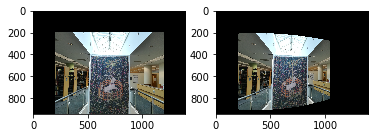

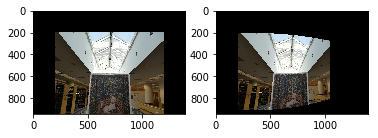

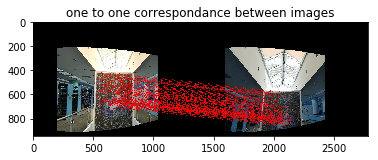

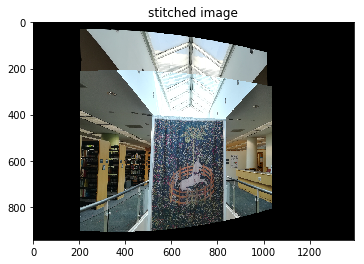

-12.531395631687095


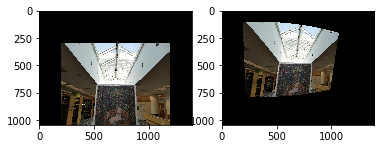

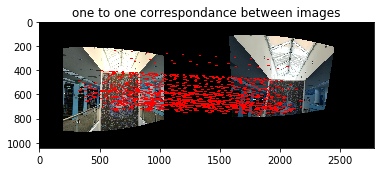

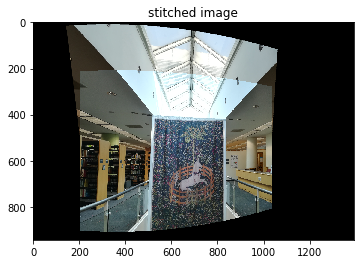

-19.49200885657539


In [172]:
theta_0=0
phi_0=0
K_down=K/4
K_down[2][2]=1

img1 = cv2.imread("spherical/img_r0c0.jpg",1)
img2 = cv2.imread("spherical/img_r+1c0.jpg",1)

# offset = getOffset(K_down,phi_0)

sph1 = resize_SphericalWarping(img1,K_down,theta_0,phi_0,200)
# 
output1,theta1,phi1 = sphericalStitching(sph1,img2,K_down,theta_0,phi_0,200)

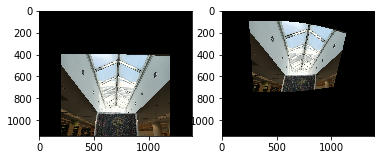

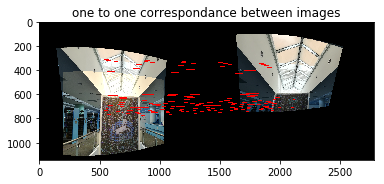

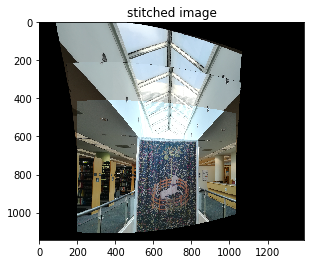

-29.567278213440595


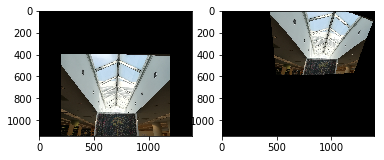

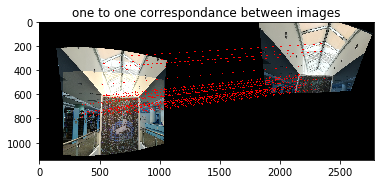

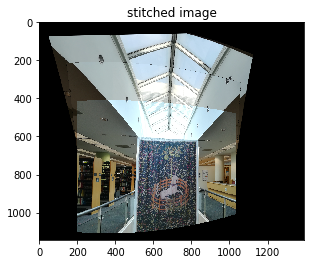

-24.28287322479179


In [186]:

img3 = cv2.imread("spherical/img_r+2c0.jpg",1)
output1_padded = cv2.copyMakeBorder(output1,200,0,0,0,cv2.BORDER_CONSTANT)
output2,theta2,phi2 = sphericalStitching(output1_padded,img3,K_down,theta1,phi1,400)


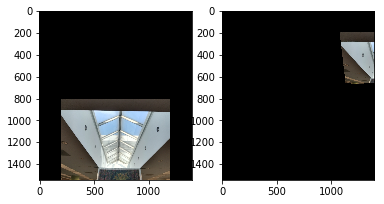

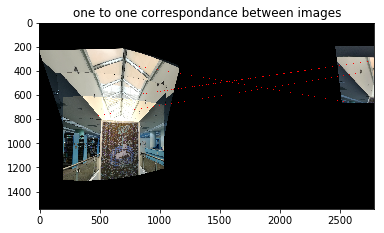

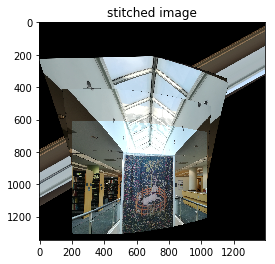

2272.4704139208266


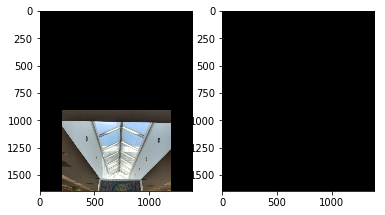

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\features2d\src\matchers.cpp:744: error: (-215) _queryDescriptors.type() == trainDescType in function cv::BFMatcher::knnMatchImpl


In [174]:

img4 = cv2.imread("spherical/img_r+3c0.jpg",1)
output2_padded = cv2.copyMakeBorder(output2,200,0,0,0,cv2.BORDER_CONSTANT)
output3,theta3,phi3 = sphericalStitching(output2_padded,img4,K_down,theta2,phi2,800)
